# Identifying Bus stops by people activities points

## Steps


1. Understand the problem and similar situations. 
2. Analyze and format Geojson data.
3. Research solutions involving data science solutions regarding clustering methodologies
4. Build a clustering method for activity points and consider following options:
	a. K-means method
	b. Hierarchical clustering
	c. DBSCAN clustering
5. After research DBSCAN is fitted candidate to be a model for clustering. Then configure parameter for use haversine, this metric is an equation important in navigation, giving great-circle distances between two points on a sphere from their longitudes and latitudes.
6. Choose different  kilometer distance to define the epiloson of the DBSCAN. Test form 300 meters to 900 meter were produced. The best length is 800 meters, the method give more accuracy and cover more distance points. 
7. Take central points from each created cluster, these points are the bus stops accordingly with the clustering obtained by people activities points and their density. 
9. Display bus stops and routes in a web map. 
10. Recommended steps

## Execution

1. Run ‘python manage.py runserver’ inside bus_stops folder.
2. Open http://127.0.0.1:8000/
3. Visualize the results. 

## Code and Steps

## Step 1 and 2

In [2]:
# import python packages
import json
import warnings
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import folium

# Get coordinates from Geojson objects
def get_coordinates(geojson,type):

    with open(geojson) as f:
        data = json.load(f)

    data = data['features']
    if type == "p":
        data= [ dict({"lat": object['geometry']['coordinates'][1], "lon": object['geometry']['coordinates'][0]}.items()
              + object['properties'].items()) for object in data ]
    else:## 
        data = [dict({"coordinates": object['geometry']['coordinates']}.items()
               + object['properties'].items()) for object in data]
    return pd.DataFrame(data)

# Obtain coordinates from activity points and routes
dataroutes = get_coordinates('stops/routes.geojson',"r")
datapoints = get_coordinates('stops/activity_points.geojson',"p")
coords = datapoints.as_matrix(columns=['lat', 'lon'])
coords_routes = dataroutes['coordinates'].tolist()


## Steps 3 and 4

Research Sources:

- Diker, Ahmet Can, and Elvin Nasibov. "Estimation of traffic congestion level via fn-dbscan algorithm by using gps data." Problems of Cybernetics and Informatics (PCI), 2012 IV International Conference. IEEE, 2012.
- Rizzo, Giuseppe, et al. "Geographic summaries from crowdsourced data." European Semantic Web Conference. Springer International Publishing, 2014.
- da Silva, Ticiana L. Coelho, et al. "Efficient and Distributed DBScan Algorithm Using MapReduce to Detect Density Areas on Traffic Data." ICEIS (1). 2014.
- Chen, Bensong, George N. Rouskas, and Rudra Dutta. "On hierarchical traffic grooming in WDM networks." IEEE/ACM Transactions on Networking (TON) 16.5 (2008): 1226-1238.
- http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/

Chose DBSCAN by their advantages:

- DBSCAN does not require one to specify the number of clusters in the data a priori, as opposed to k-means.
- DBSCAN can find arbitrarily shaped clusters. It can even find a cluster completely surrounded by (but not connected to) a different cluster. Due to the MinPts parameter, the so-called single-link effect (different clusters being connected by a thin line of points) is reduced.
- DBSCAN has a notion of noise, and is robust to outliers.
- The parameters minPts and ε can be set by a domain expert, if the data is well understood.

## Step 5

In [50]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

800.0 meters used for haversine metric
Estimated number of clusters: 31
Silhouette coefficient: 0.605


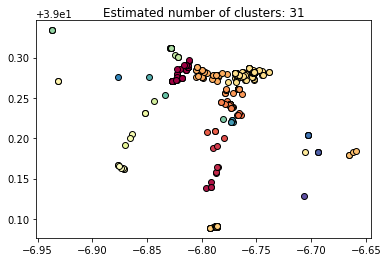

In [51]:
    warnings.filterwarnings('ignore')
    # define the number of kilometers in one radian
    kms_per_radian = 6371.0088
    km = 0.8
    # define epsilon as 1.5 kilometers, converted to radians for use by haversine
    epsilon = km / kms_per_radian
    print(str(km*1000) + " meters used for haversine metric")

    # Execute method DBSCAN, use just 1 min_samples  
    # because of isolate user activity points
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_

    # get the number of clusters
    num_clusters = len(set(cluster_labels))

    # Print the outcome
    print('Estimated number of clusters: %d' % num_clusters)
    print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

    # turn the clusters in to a pandas series, where each element is a cluster of points
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

    centermost_points = clusters.map(get_centermost_point)

    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)

    # from these lats/lons create a new df of one representative point for each cluster
    rep_points = pd.DataFrame({'lon': lons, 'lat': lats})

    core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
    unique_labels = set(cluster_labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (cluster_labels == k)

        xy = coords[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)

        xy = coords[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % num_clusters)
    # Show clusters
    plt.show()

## Steps 6 and 7

**Result with different meters distance were executed**

- 300 meters - Estimated number of clusters: 79 - Silhouette coefficient: 0.673

- 400 meters - Estimated number of clusters: 59 - Silhouette coefficient: 0.661

- 500 meters - Estimated number of clusters: 52 - Silhouette coefficient: 0.667

- 600 meters - Estimated number of clusters: 45 - Silhouette coefficient: 0.473

- 700 meters - Estimated number of clusters: 38 - Silhouette coefficient: 0.489

- 800 meters - Estimated number of clusters: 31 - Silhouette coefficient: 0.605

- 900 meters - Estimated number of clusters: 27 - Silhouette coefficient: 0.200

800 meters demonstrate best visual results for bus stops and good Silhouette coefficient

## Step 8

In [57]:
    # Create a web map from the first bus stop
    map = folium.Map(location=[lats[0], lons[0]], zoom_start=13,
                       tiles='Stamen Terrain')
    
    # Take all central points and marked them in the web map
    index = 1
    for lat, lon in zip(lats, lons):
        folium.Marker([lat, lon], popup=("Bus Stop for group: "+ str(index))).add_to(map)
        index+=1

    # Draw routes inside web map
    for route in coords_routes:
        route = [tuple([coordinates[1],coordinates[0]]) for coordinates in route]
        folium.PolyLine(route, color="orange", weight=2.5, opacity=1).add_to(map)

    # Save map as HTML for display as first page
    map.save('stops/templates/index.html')

In [23]:
from IPython.display import IFrame
IFrame('stops/templates/index.html', width=1000, height=650)

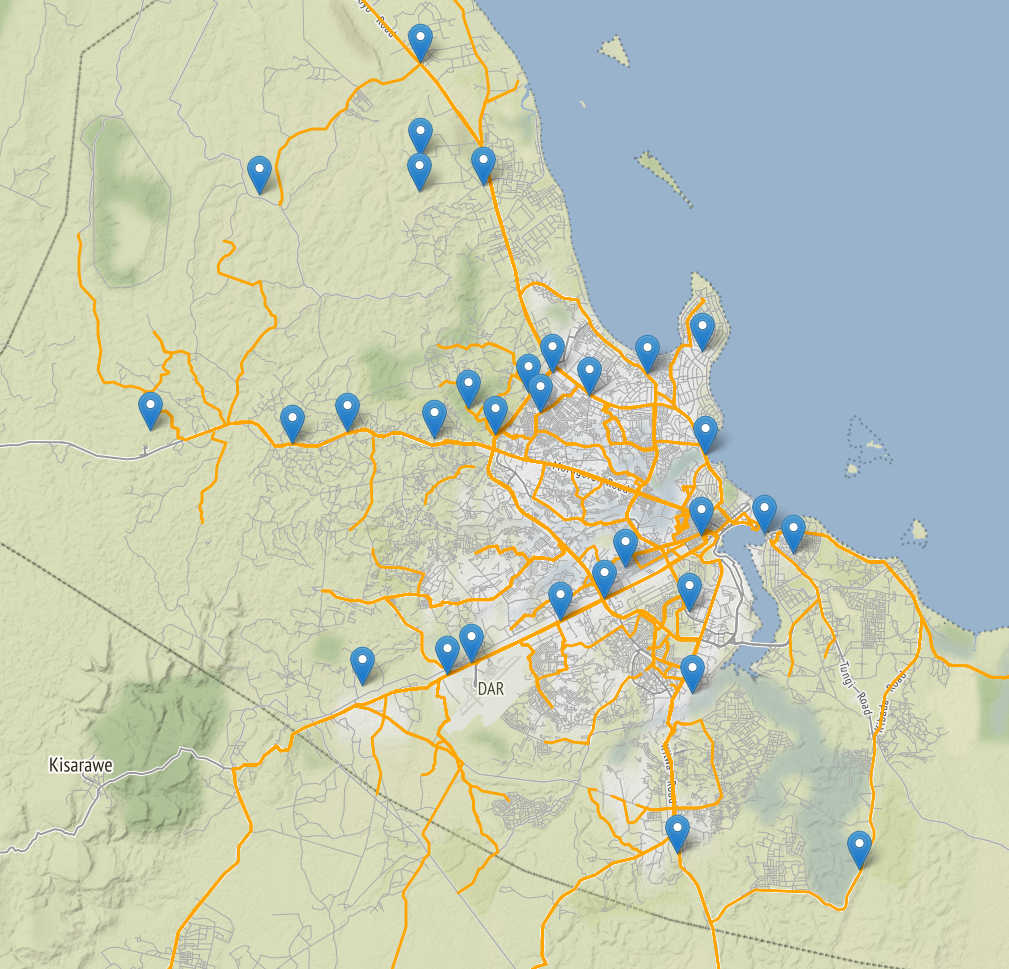

In [59]:
from IPython.display import Image
Image(filename='stops/templates/map.png')

## Step 9

** Recommended steps to follow ** 

- All bus stops located inside a determined route.
- Production code, test and organization.
- Calibration of the DBSCAN.
- Test other clustering methods.
- Use routes data as feedback for better choice of central points. 